In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

### Global segments

In [6]:
rfiles = glob('metadata/2h/*.json')
print(len(rfiles))

242


In [7]:
routes = []
for rfile in tqdm(rfiles):
    with open(rfile) as fl:
        robj = json.load(fl)
    routes.append(robj)
#     print(rfile, robj['integ'])

100%|██████████| 242/242 [00:17<00:00, 13.83it/s]


In [9]:
routes = sorted(routes, key=lambda obj: 1-obj['integ'])
print(routes[0]['name'], routes[0]['integ'])

Q10_0 0.9033231431159421


In [13]:
segrefs = []
ri = 0
for route in routes:
    if route['integ'] < 0.75:
        break
    if route['seglen'] < 20:
        continue
    pad = int(route['seglen'] /3)
    for si in range(pad, pad*2):
        segrefs.append((route['name'], si))
    ri += 1
print(ri)
print(len(segrefs))
print(segrefs[0])

60
927
('Q10_0', 13)


In [15]:
# assert False # Do not re-run this 
# from numpy.random import shuffle
# shuffle(segrefs)

In [90]:
subsamp = segrefs[:100]
print(len(subsamp))

100


In [91]:
# with open('test_segs.json', 'w') as fl:
#     json.dump(subsamp, fl, indent=4)

In [92]:
# RNN
jobs=4
nj = int(len(subsamp) // jobs)
for ji in range(jobs):
    with open('scripts/test_mean_rnn_%d.sh' % ji, 'w') as fl:
        fl.write('#!/bin/bash\n\n')
        for rname, sind in subsamp[ji*nj:(ji+1)*nj]:
            fl.write('python3 batch_RNN.py %s %d\n' % (rname, sind))

In [93]:
# RNN-0
jobs=4
nj = int(len(subsamp) // jobs)
for ji in range(jobs):
    with open('scripts/test_mean_rnn0_%d.sh' % ji, 'w') as fl:
        fl.write('#!/bin/bash\n\n')
        for rname, sind in subsamp[ji*nj:(ji+1)*nj]:
            fl.write('python3 batch_RNN_0.py %s %d\n' % (rname, sind))

In [94]:
# Linear
jobs=4
nj = int(len(subsamp) // jobs)
for ji in range(jobs):
    with open('scripts/test_mean_linear_%d.sh' % ji, 'w') as fl:
        fl.write('#!/bin/bash\n\n')
        for rname, sind in subsamp[ji*nj:(ji+1)*nj]:
            fl.write('python3 batch_Linear.py %s %d\n' % (rname, sind))

In [95]:
# Graph
jobs=4
nj = int(len(subsamp) // jobs)
for ji in range(jobs):
    with open('scripts/test_mean_graph_%d.sh' % ji, 'w') as fl:
        fl.write('#!/bin/bash\n\n')
        for rname, sind in subsamp[ji*nj:(ji+1)*nj]:
            fl.write('python3 batch_Graph.py %s %d\n' % (rname, sind))

### Delta segments

In [97]:
sfiles = glob('data/stopcodes_sequence/*_0.txt')
print(len(sfiles))

328


In [107]:
seg_branch = {}
for sfile in sfiles:
    with open(sfile) as fl:
        stops = list(filter(lambda ent: ent, fl.read().split('\n')))
    segs = []
    for si in range(1, len(stops)):
        segid = '%s-%s' % (stops[si-1], stops[si])
        segs.append(segid)
    for si, seg in enumerate(segs):
        if seg not in seg_branch:
            seg_branch[seg] = dict(
                name=fileName(sfile),
                segid=seg,
                outs=[],
                ins=[],
            )
        if si < len(segs) -1 :
            if segs[si+1] not in seg_branch[seg]['outs']:
                seg_branch[seg]['outs'].append(segs[si+1])
        if si > 0: 
            if segs[si-1] not in seg_branch[seg]['ins']:
                seg_branch[seg]['ins'].append(segs[si-1])

In [108]:
count_outs = []
count_ins = []
for sid, obj in seg_branch.items():
    count_outs.append(len(obj['outs']))
    count_ins.append(len(obj['ins']))

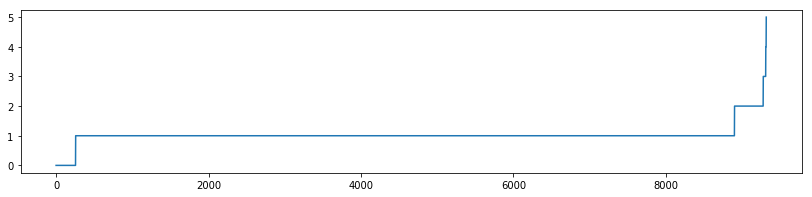

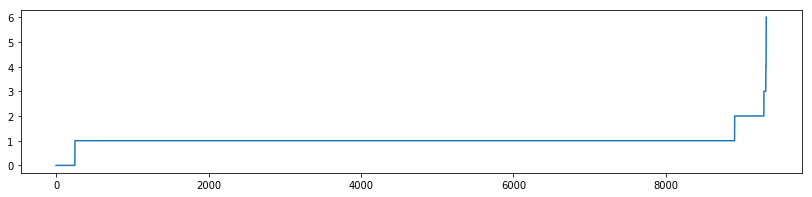

In [109]:
plt.figure(figsize=(14, 3))
plt.plot(sorted(count_outs))
plt.show(); plt.close()
plt.figure(figsize=(14, 3))
plt.plot(sorted(count_ins))
plt.show(); plt.close()

### Filter nodes with many adj

In [110]:
byadj = {
    2: [],
    3: [],
#     4: [],
}

def hasLoop(root, ls={}):
    if root['segid'] in ls: 
        return True
    ls[root['segid']] = 1
        
    loop = False
    for child in root['outs']:
        loop = loop or hasLoop(child, ls)
        
    return loop

def fill(obj, depth=2):
    outs = []
    if depth > 1:
        for sid in obj['outs']:
            neighbor = seg_branch[sid]
            nobj = fill(neighbor, depth-1)
            outs.append(nobj)
        
    new = dict(
        name=obj['name'], 
        segid=obj['segid'], 
        outs=outs)
    return new

for sid, obj in seg_branch.items():
    nOuts = len(obj['outs'])
    if nOuts in byadj:
        obj = fill(obj)
        if hasLoop(obj, {}):
            assert False
        byadj[nOuts].append(obj)
        
print(len(byadj[2]))
print(len(byadj[3]))
# print(len(byadj[4]))

377
33


In [111]:
print(byadj[2][0])

{'name': 'B62_0', 'segid': '306762-303813', 'outs': [{'name': 'B62_0', 'segid': '303813-306763', 'outs': []}, {'name': 'B48_0', 'segid': '303813-303814', 'outs': []}]}


In [ ]:
with 